In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We are here importing all the libraries needed

In [ ]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
from pandas import Series, DataFrame, concat
from matplotlib import pyplot
from pandas.plotting import lag_plot, autocorrelation_plot
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from datetime import datetime
from numpy import mean
from numpy import std
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
warnings.filterwarnings('ignore')

We are using data present on GitHub to extract the information we need about covid-19 cases. The data we have here represents the several cases for the myriad of countries around the globe. Each row in the csv file we are reading from represents one country exactly with columns being:

1- Province/State	column 

2- Country/Region column

3- The two columns after (named Lat and Long), were mostly used because some countries in the file are reported to the state/province level, for example Austarlia. However, this is not the case for Lebanon and thus we have only one Long and Lat value per each pf these columns relating to Lebanon, since we only have one row for it.

4- All other columns represent dates, with cell values representing the number of [death, recovered, etc] cases we have so far up to that specific day. 

It makes sense now to read the three csv files on recovered, confirmed and death, extract only the data relating to Lebanon, drop all columns named Province/State, Country/Region, Long and Lat, process and glue the results in a single data frame. 

In [ ]:
import requests
sns.set(rc={'figure.figsize':(10.7,5.27)})
##############
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
res = requests.get(url, allow_redirects=True)
with open('time_series_covid19_recovered_global.csv','wb') as file:
    file.write(res.content)
recovered_global = pandas.read_csv('time_series_covid19_recovered_global.csv')
##############

##############
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
res = requests.get(url, allow_redirects=True)
with open('time_series_covid19_deaths_global.csv','wb') as file:
    file.write(res.content)
deaths_global = pandas.read_csv('time_series_covid19_deaths_global.csv')
##############

##############
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
res = requests.get(url, allow_redirects=True)
with open('time_series_covid19_confirmed_global.csv','wb') as file:
    file.write(res.content)
cases_global = pandas.read_csv('time_series_covid19_confirmed_global.csv')

We are here choosing the data related to Lebanon (recorded additional cases, recoveries and death). In addition, we are processing data to obtain daily cases instead of total cases like we originally had in our data from GitHub.

In [ ]:
cases_Lebanon = cases_global[cases_global["Country/Region"] == "Lebanon"]
deaths_Lebanon = deaths_global[deaths_global["Country/Region"] == "Lebanon"]
recovered_Lebanon = recovered_global[recovered_global["Country/Region"] == "Lebanon"]

cases_Lebanon = cases_Lebanon.drop(['Lat','Long','Province/State','Country/Region'], axis = 1, errors = 'raise')
recovered_Lebanon = recovered_Lebanon.drop(['Lat','Long','Province/State','Country/Region'], axis = 1, errors = 'raise')
deaths_Lebanon = deaths_Lebanon.drop(['Lat','Long','Province/State','Country/Region'], axis = 1, errors = 'raise')

dates = []
casesLebanon = []
recoveredLebanon = []
deathsLebanon = []
#putting all the data inside lists, to later be converted to a dataframe after being proceesed
for col in cases_Lebanon.columns: 
    dates.append(col)

for i in range(0, len(dates)):
  casesLebanon.append(cases_Lebanon.iloc[0][i])

for i in range(0, len(dates)):
  recoveredLebanon.append(recovered_Lebanon.iloc[0][i])

for i in range(0, len(dates)):
  deathsLebanon.append(deaths_Lebanon.iloc[0][i])

#processing the lists to obtain additional cases instead of total
def process(L):
  L1 = []
  L1.append(L[0])
  for i in range(1,len(L)-1):
    L1.append(L[i] - L[i-1])
  return L1

casesL = process(casesLebanon)
recoveredL = process(recoveredLebanon)
deathsL = process(deathsLebanon)
dates = dates[1:]


lebanon = pandas.DataFrame(list(zip(casesL, recoveredL, deathsL)), 
               columns =['Confirmed Cases', 'Recovered Cases', 'Recorded Deaths'], index = dates)

lebanon.tail() #this is our final data frame

,Confirmed Cases,Recovered Cases,Recorded Deaths
11/19/20,2084,133,13
11/20/20,1909,876,16
11/21/20,1709,1281,16
11/22/20,1628,1450,10
11/23/20,1193,1532,6


We now move on to the data related to the actual Lebanese lira rate and Syrian rate. As before, we are using the dates as row indices.

In [ ]:
rates = pandas.read_excel("/content/drive/My Drive/lira276.xlsx")
syr = pandas.read_excel("/content/drive/My Drive/syria276.xlsx")

In [ ]:
syr.columns = ["date","null","SyrianRate"]
syr.drop("null", axis = 1, inplace = True) #drop the useless column
syr.drop_duplicates(subset ="date", keep = "first", inplace = True) #drop duplicates for date
syr["date"] = pandas.to_datetime(syr["date"])
syr.set_index('date', inplace = True) #setting the dates as index, which will be done to all dataframes
syr.tail()

,SyrianRate
date,
2020-10-11,2360.0
2020-10-12,2330.0
2020-10-13,2320.0
2020-10-14,2330.0
2020-10-15,NaN


In [ ]:
rates.drop([rates.index[0]], inplace = True)
#choose appropriate names for columns in data frame
rates.columns = ["Date", "Time", "BM Buy","BM Sell", "Cheque Buy", "Cheque Sell", "Bank", "Official","SyndicateB","SyndicateS", "ParallelB","ParallelS"]
rates['Date'] = rates['Date'].apply(lambda x: datetime.strptime(x,'%a, %b %d, %Y')) #convert string to the correct format (date)
rates.head()

,Date,Time,BM Buy,BM Sell,Cheque Buy,Cheque Sell,Bank,Official,SyndicateB,SyndicateS,ParallelB,ParallelS
1,2020-10-13,11:00:00,7800,8100,$0.34,$0.35,3900,1507.5,-,-,-,-
2,2020-10-12,16:00:00,8100,8300,$0.33,$0.34,3900,1507.5,-,-,-,-
3,2020-10-12,10:00:00,8200,8500,$0.32,$0.34,3900,1507.5,-,-,-,-
4,2020-10-11,-,-,-,-,-,3900,1507.5,-,-,-,-
5,2020-10-10,12:00:00,8400,8600,$0.32,$0.33,3900,1507.5,-,-,-,-


In [ ]:
rates.drop_duplicates(subset ="Date", keep = 'first', inplace = True) #drop the duplicates for dates
rates.set_index('Date', inplace = True) #we select date to be index like rest of data frames

We can see that the official government rate hasn't changed at all. This is a zero variance column that we will drop as its presence will add zero information to our model. We will later study the case of near-zero variance columns. 

In [ ]:
unq = len(rates["Official"].unique())
print("We have {} unique values of official government rate.".format(unq))
rates.drop("Official", axis = 1, inplace = True)
rates.head()

We have 1 unique values of official government rate.


,Time,BM Buy,BM Sell,Cheque Buy,Cheque Sell,Bank,SyndicateB,SyndicateS,ParallelB,ParallelS
Date,,,,,,,,,,
2020-10-13,11:00:00,7800,8100,$0.34,$0.35,3900,-,-,-,-
2020-10-12,16:00:00,8100,8300,$0.33,$0.34,3900,-,-,-,-
2020-10-11,-,-,-,-,-,3900,-,-,-,-
2020-10-10,12:00:00,8400,8600,$0.32,$0.33,3900,-,-,-,-
2020-10-09,11:00:00,8700,8900,$0.32,$0.33,3900,3850,3900,-,-


In [ ]:
merge = pandas.merge(rates,syr, how='inner', left_index=True, right_index=True) #we inner merge the 2 dataframes
merge = pandas.merge(merge, lebanon, how='inner', left_index=True, right_index=True) #we inner merge the 2 dataframes
merge.drop("Time", axis=1, inplace = True) #drop time since it is irrelevant to our data

We perform some more cleaning to ensure that the format allows the data to be transformed into numerics. We also replace all sorts of missing value symbols with NAN. Finally, we drop BM SELL from the features, and use BM BUY as the target variable. We now move to impute any missing values in the features. 

In [ ]:
merge = merge.replace("-",np.nan) #to replace - with nan values
merge = merge.replace("","$") #to replace - with nan values
merge['Cheque Buy'] = merge['Cheque Buy'].str.replace(',', '').str.replace('$', '')
merge['Cheque Sell'] = merge['Cheque Sell'].str.replace(',', '').str.replace('$', '') #we remove the dollar sign from our cheque sell and buy to later convert it to numerics
merge["weekday"] = merge.index.to_series().dt.dayofweek
merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 2020-10-13 to 2020-01-23
Freq: -1D
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BM Buy           203 non-null    float64
 1   BM Sell          203 non-null    float64
 2   Cheque Buy       16 non-null     object 
 3   Cheque Sell      16 non-null     object 
 4   Bank             170 non-null    float64
 5   SyndicateB       129 non-null    float64
 6   SyndicateS       129 non-null    float64
 7   ParallelB        195 non-null    float64
 8   ParallelS        0 non-null      float64
 9   SyrianRate       228 non-null    float64
 10  Confirmed Cases  265 non-null    int64  
 11  Recovered Cases  265 non-null    int64  
 12  Recorded Deaths  265 non-null    int64  
 13  weekday          265 non-null    int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 31.1+ KB


In [ ]:
cols = ['BM Buy']
merge.loc[:,cols] = merge.loc[:,cols].ffill() 
merge = merge.iloc[::-1]

y = merge["BM Buy"] #target variable
y2 = merge.filter(['BM Buy','BM Sell'], axis=1) #to be used later to create 
X = merge.drop("BM Buy", axis = 1) #remove target variable
X.drop("BM Sell", axis = 1, inplace = True) #can't be used to predict black market buy rate
X = X.apply(pd.to_numeric, errors='coerce') #make sure all values are numeric
y.head()

2020-01-23    2100.0
2020-01-24    2150.0
2020-01-25    2150.0
2020-01-26    2160.0
2020-01-27    2160.0
Freq: D, Name: BM Buy, dtype: float64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


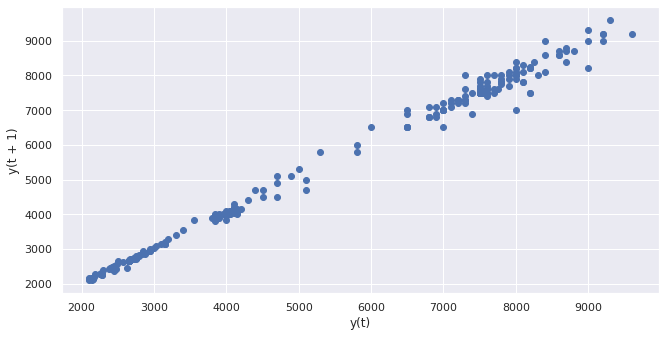

In [ ]:
lag_plot(y)
pyplot.show()

 The points cluster form a diagonal line from the bottom-left to the top-right of the plot.
This suggests a positive correlation relationship between the value at time t and the value at time t+1.

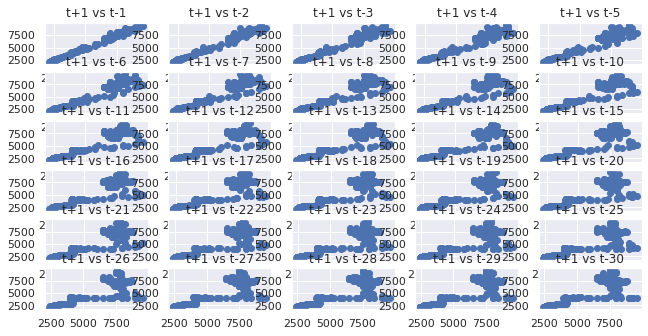

In [ ]:
values = DataFrame(y.values)
lags = 30
columns = [values]
for i in range(1,(lags + 1)):
  columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
  columns.append('t-' + str(i))
dataframe.columns = columns
pyplot.figure(1)
for i in range(1,(lags + 1)):
  ax = pyplot.subplot(6,5,i)
  ax.set_title('t+1 vs t-' + str(i))
  pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
pyplot.show()

We notice that after 15 lags, the correlation between the variables and the lags becomes less evident as we don't see a clear diagonal shape anymore. We will choose 1,5,10 and 15 days back to capture the relationship between the output variable and the lags.

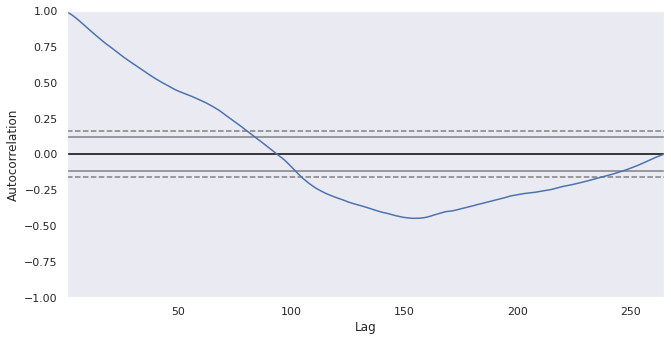

In [ ]:
autocorrelation_plot(y)
pyplot.show()

The resulting plot shows lag along the x-axis and the correlation on the y-axis. Dotted lines
are provided that indicate any correlation values above those lines are statistically signicant
(meaningful). We can see that lags below 70 are statistically significant, and since our dataset is relatively small, we chose will try to capture the lags with 5,15 and 30 days.

We will generate features which will be usefull for the time series model we will be using in the next phases. We will generate average buy and sell rates, standard deviations and return rates for both sell and buy.

In [ ]:
def generate_features(df):
    df_new = pd.DataFrame()

    #df_new['buy'] = df
    df_new['buy_1'] = df.shift(1)

    #rolling mean buy rate
    df_new['buy_5_mean'] = df.rolling(window=5).mean().shift(1)
    df_new['buy_10_mean'] = df.rolling(window=10).mean().shift(1)
    df_new['buy_15_mean'] = df.rolling(window=15).mean().shift(1)

    #mean buy ratio
    df_new['buy_5_10'] = df_new['buy_5_mean'] / df_new['buy_10_mean']
    df_new['buy_10_15'] = df_new['buy_10_mean'] / df_new['buy_15_mean']
    df_new['buy_5_15'] = df_new['buy_5_mean'] / df_new['buy_15_mean']

    #rolling max buy rate
    df_new['buy_5_max'] = df.rolling(window=5).max().shift(1)
    df_new['buy_10_max'] = df.rolling(window=10).max().shift(1)
    df_new['buy_15_max'] = df.rolling(window=15).max().shift(1)

    #rolling min buy rate
    df_new['buy_5_min'] = df.rolling(window=5).min().shift(1)
    df_new['buy_10_min'] = df.rolling(window=10).min().shift(1)
    df_new['buy_15_min'] = df.rolling(window=15).min().shift(1)

    #rolling std buy rate
    df_new['buy_5_std'] = df.rolling(window=5).std().shift(1)
    df_new['buy_10_std'] = df.rolling(window=10).std().shift(1)
    df_new['buy_15_std'] = df.rolling(window=15).std().shift(1)

    #Exponential moving averages provide more weight to recent values, which in finance are generally useful.
    #rolling exponential average on buy rate
    df_new['buy_5_emean'] = df.ewm(span=5,adjust=False).mean().shift(1)
    df_new['buy_10_emean'] = df.ewm(span=10,adjust=False).mean().shift(1)
    df_new['buy_15_emean'] = df.ewm(span=15,adjust=False).mean().shift(1)                                       
                                                   
    # return for buy
    df_new['buy_return_1'] = ((df - df.shift(1)) / df.shift(1)).shift(1)
    df_new['buy_return_5'] = ((df - df.shift(5)) / df.shift(5)).shift(1)
    df_new['buy_return_10'] = ((df - df.shift(10)) / df.shift(10)).shift(1)
    df_new['buy_return_15'] = ((df - df.shift(15)) / df.shift(15)).shift(1)                                                
    
    #average of return for buy
    df_new['buy_moving_avg_5'] = df_new['buy_return_1'].rolling(window=5).mean()
    df_new['buy_moving_avg_10'] = df_new['buy_return_1'].rolling(window=10).mean()
    df_new['buy_moving_avg_15'] = df_new['buy_return_1'].rolling(window=15).mean()

    #slope or 1st derivative
    df_new['buy_slope_5'] = df.rolling(window = 5).apply(lambda x: np.polyfit(range(5), x, 1)[0]).values
    df_new['buy_slope_10'] = df.rolling(window = 10).apply(lambda x: np.polyfit(range(10), x, 1)[0]).values
    df_new['buy_slope_15'] = df.rolling(window = 15).apply(lambda x: np.polyfit(range(15), x, 1)[0]).values

    #2nd derivative
    df_new['buy_deriv2_5'] = df_new['buy_slope_5'].rolling(window = 5).apply(lambda x: np.polyfit(range(5), x, 1)[0]).values
    df_new['buy_deriv2_10'] = df_new['buy_slope_10'].rolling(window = 10).apply(lambda x: np.polyfit(range(10), x, 1)[0]).values
    df_new['buy_deriv2_15'] = df_new['buy_slope_15'].rolling(window = 15).apply(lambda x: np.polyfit(range(15), x, 1)[0]).values
    
    return df_new

new_features_X = generate_features(y)
new_features_X.columns


Index(['buy_1', 'buy_5_mean', 'buy_10_mean', 'buy_15_mean', 'buy_5_10',
       'buy_10_15', 'buy_5_15', 'buy_5_max', 'buy_10_max', 'buy_15_max',
       'buy_5_min', 'buy_10_min', 'buy_15_min', 'buy_5_std', 'buy_10_std',
       'buy_15_std', 'buy_5_emean', 'buy_10_emean', 'buy_15_emean',
       'buy_return_1', 'buy_return_5', 'buy_return_10', 'buy_return_15',
       'buy_moving_avg_5', 'buy_moving_avg_10', 'buy_moving_avg_15',
       'buy_slope_5', 'buy_slope_10', 'buy_slope_15', 'buy_deriv2_5',
       'buy_deriv2_10', 'buy_deriv2_15'],
      dtype='object')

In [ ]:
X = pandas.merge(X,new_features_X, how='inner', left_index=True, right_index=True)
X = X.shift(-1)
y = y.shift(-1)
y.head(10)

2020-01-23    2150.0
2020-01-24    2150.0
2020-01-25    2160.0
2020-01-26    2160.0
2020-01-27    2150.0
2020-01-28    2100.0
2020-01-29    2100.0
2020-01-30    2160.0
2020-01-31    2150.0
2020-02-01    2160.0
Freq: D, Name: BM Buy, dtype: float64

In [ ]:
X.drop(X.tail(1).index,inplace=True)
y.drop(y.tail(1).index,inplace=True)

In [ ]:
y.tail()

2020-10-08    8700.0
2020-10-09    8400.0
2020-10-10    8100.0
2020-10-11    8100.0
2020-10-12    7800.0
Freq: D, Name: BM Buy, dtype: float64

We are going to apply imputation using KNN (KNNImputer), as a hyper-parameter tuning application, we will look at how KNN imputer performs given different number of nearest neighbors chosen.  The code as follows.

In [ ]:
#DO NOT RUN THIS IT TAKES FOREVER
strategies = [i for i in [1,3,5,7,9,15,18,21]]
results = []
for s in strategies:
  # create the modeling pipeline
  pipeline = Pipeline(steps=[("i", KNNImputer(n_neighbors=s)), ("m", RandomForestRegressor())])
  # evaluate the model
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) 
  scores = cross_val_score(pipeline, X, y, scoring="r2", cv=cv, n_jobs=-1)
  # store results
  results.append(scores) 

KeyboardInterrupt: ignored

In [ ]:
plt.boxplot(results, showmeans=True)
plt.show()

The plot shows that the 8th value (21 neighbors) outperforms all other values of k and produces an r2 score of around 0.995. Besides KNNImputer, we are interested in looking at how other imputation models perform given our data. We achieve our goal using an iterativeImputer. We will pass the following three models: Ada Boost, gradient boost and the basic linear regression.

In [ ]:

#DO NOT RUN THIS IT TAKES FOREVER
models = [AdaBoostRegressor(), LinearRegression(), GradientBoostingRegressor()]
results = []
for s in models:
  # create the modeling pipeline
  pipeline = Pipeline(steps=[('i', IterativeImputer(estimator = s)), ('m', RandomForestRegressor())])  # evaluate the model
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1) 
  scores = cross_val_score(pipeline, X, y, scoring="r2", cv=cv, n_jobs=-1)
  # store results
  results.append(scores)

In [ ]:
print(results)
plt.boxplot(results, showmeans=True)
plt.show()

We can see that the 3rd model, being Gradient Boost Regressor, beats the other two. We can also see that it performs better than the KNN imputer having a narrower deviation, thus we will use it to impute our data.

In [ ]:
#choosing the best strategy, like described above
imputer = IterativeImputer(estimator = GradientBoostingRegressor())
imputer.fit(X)
Xtrans = imputer.transform(X)
Xt = pd.DataFrame(Xtrans) #this is the final dataset for X we will be using

In [ ]:
Xt.set_index(X.index, inplace = True) #we set the index to be the same as it was in the beginning as well as columns
Xt.columns = ['Cheque Buy', 'Cheque Sell', 'Bank', 'SyndicateB', 'SyndicateS',
       'ParallelB', 'SyrianRate', 'Confirmed Cases',
       'Recovered Cases', 'Recorded Deaths', 'weekday', 'buy_1', 'buy_5_mean', 'buy_10_mean', 'buy_15_mean', 'buy_5_10',
       'buy_10_15', 'buy_5_15', 'buy_5_max', 'buy_10_max', 'buy_15_max',
       'buy_5_min', 'buy_10_min', 'buy_15_min', 'buy_5_std', 'buy_10_std',
       'buy_15_std', 'buy_5_emean', 'buy_10_emean', 'buy_15_emean',
       'buy_return_1', 'buy_return_5', 'buy_return_10', 'buy_return_15',
       'buy_moving_avg_5', 'buy_moving_avg_10', 'buy_moving_avg_15',
       'buy_slope_5', 'buy_slope_10', 'buy_slope_15', 'buy_deriv2_5',
       'buy_deriv2_10', 'buy_deriv2_15']
Xt.tail()

,Cheque Buy,Cheque Sell,Bank,SyndicateB,SyndicateS,ParallelB,SyrianRate,Confirmed Cases,Recovered Cases,Recorded Deaths,weekday,buy_1,buy_5_mean,buy_10_mean,buy_15_mean,buy_5_10,buy_10_15,buy_5_15,buy_5_max,buy_10_max,buy_15_max,buy_5_min,buy_10_min,buy_15_min,buy_5_std,buy_10_std,buy_15_std,buy_5_emean,buy_10_emean,buy_15_emean,buy_return_1,buy_return_5,buy_return_10,buy_return_15,buy_moving_avg_5,buy_moving_avg_10,buy_moving_avg_15,buy_slope_5,buy_slope_10,buy_slope_15,buy_deriv2_5,buy_deriv2_10,buy_deriv2_15
2020-10-08,0.320000,0.330000,3900.0,3850.000000,3900.000000,3799.975654,2318.528063,1367.0,640.0,6.0,4.0,8800.0,8680.0,8505.0,8316.666667,1.020576,1.022645,1.043687,8800.0,8800.0,8800.0,8600.0,8200.0,7600.0,83.666003,224.165118,361.379632,8672.172825,8511.050403,8365.428384,0.011494,0.023256,0.073171,0.135484,0.004624,0.007121,0.008598,30.0,61.515152,66.607143,-13.0,-1.836547,4.065051
2020-10-09,0.320000,0.330000,3900.0,3850.000136,3900.000136,3799.975654,2320.000000,1426.0,647.0,11.0,5.0,8700.0,8700.0,8555.0,8390.000000,1.016949,1.019666,1.036949,8800.0,8800.0,8800.0,8600.0,8200.0,7700.0,70.710678,203.374313,314.074604,8681.448550,8545.404875,8407.249836,-0.011364,0.011628,0.060976,0.144737,0.002352,0.005985,0.009131,-60.0,29.393939,47.142857,-24.0,-4.066116,2.467474
2020-10-10,0.324932,0.340443,3900.0,3850.000136,3900.000136,3799.975654,2360.000000,1388.0,312.0,5.0,6.0,8400.0,8660.0,8575.0,8436.666667,1.009913,1.016397,1.026472,8800.0,8800.0,8800.0,8400.0,8250.0,8000.0,151.657509,171.998062,249.618757,8587.632367,8518.967625,8406.343606,-0.034483,-0.023256,0.024390,0.090909,-0.004545,0.002536,0.005955,-160.0,-18.181818,26.250000,-49.0,-8.587695,0.600765
2020-10-11,0.330000,0.340000,3900.0,3850.000136,3900.000136,3799.975654,2330.000000,1010.0,782.0,4.0,0.0,8100.0,8540.0,8560.0,8443.333333,0.997664,1.013818,1.011449,8800.0,8800.0,8800.0,8100.0,8100.0,8100.0,288.097206,206.559112,238.197597,8425.088244,8442.791693,8368.050655,-0.035714,-0.068966,-0.018182,0.012500,-0.014013,-0.001645,0.000977,-200.0,-53.939394,10.714286,-69.0,-13.318641,-1.330357
2020-10-12,0.340000,0.350000,3900.0,3850.000136,3900.000136,3799.975654,2320.000000,1056.0,440.0,7.0,1.0,8100.0,8420.0,8530.0,8436.666667,0.987104,1.011063,0.998024,8800.0,8800.0,8800.0,8100.0,8100.0,8100.0,327.108545,249.666444,246.740658,8316.725496,8380.465931,8334.544323,0.000000,-0.068966,-0.035714,-0.012195,-0.014013,-0.003463,-0.000690,-210.0,-89.090909,-11.964286,-62.0,-17.654729,-3.479592


We now move to deeper Feature selection. We look at wrapper and filter methods. We will also look at the importance of each of the several features that we gathered. Given that our input and output data is numeric, common techniques in filter feature selection on such data include Pearson's correlation coefficient and Spearman's rank cefficient. We start by look at how many features are deemed important using a Linear Regressor.

In [ ]:
# enumerate each number of features
results = list()

num_features = [i for i in range(45)]

for k in num_features:
  model = KNeighborsRegressor()
  fs = SelectKBest(score_func=f_regression, k = k)
  pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, Xt, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  results.append(scores)

In [ ]:
#print(results)
print(mean(results[13]), std(results[13]))

-110.68561253561255 23.15313274449673


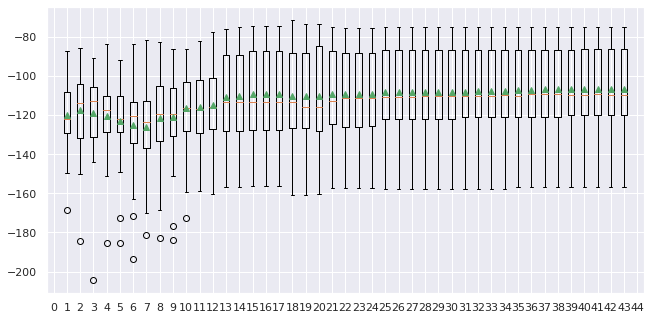

In [ ]:
# plot model performance for comparison
plt.boxplot(results, labels=num_features, showmeans=True)
plt.rcParams["figure.figsize"]=20,20
plt.show()

According to the correlation statistic, selecting 13 features (out of the 44) improves the performance of the model and lessens the complication. We can also see the performance of the model with all of its features in the plot. We care to see which features are deemed more important than the others. In other words, what 13 features should we select?

     i           col         score
23  23    buy_15_min   1929.539953
22  22    buy_10_min   3551.692074
14  14   buy_15_mean   4450.147197
29  29  buy_15_emean   6107.401126
13  13   buy_10_mean   7097.333928
20  20    buy_15_max   8855.372121
28  28  buy_10_emean   9169.784562
21  21     buy_5_min  10200.007580
19  19    buy_10_max  11179.020336
12  12    buy_5_mean  15144.509157
18  18     buy_5_max  17484.748138
27  27   buy_5_emean  17970.046983
11  11         buy_1  45398.830014

------------------------------------------

Feature 0 (Cheque Buy): 92.58915809313112
Feature 1 (Cheque Sell): 113.90371576868436
Feature 2 (Bank): 1222.3531361227072
Feature 3 (SyndicateB): 941.6688091537234
Feature 4 (SyndicateS): 941.6688091864161
Feature 5 (ParallelB): 1100.0610539198556
Feature 6 (SyrianRate): 667.0881346901738
Feature 7 (Confirmed Cases): 164.64048428062867
Feature 8 (Recovered Cases): 109.88524919016037
Feature 9 (Recorded Deaths): 113.79391013468134
Feature 10 (weekday): 0.024968

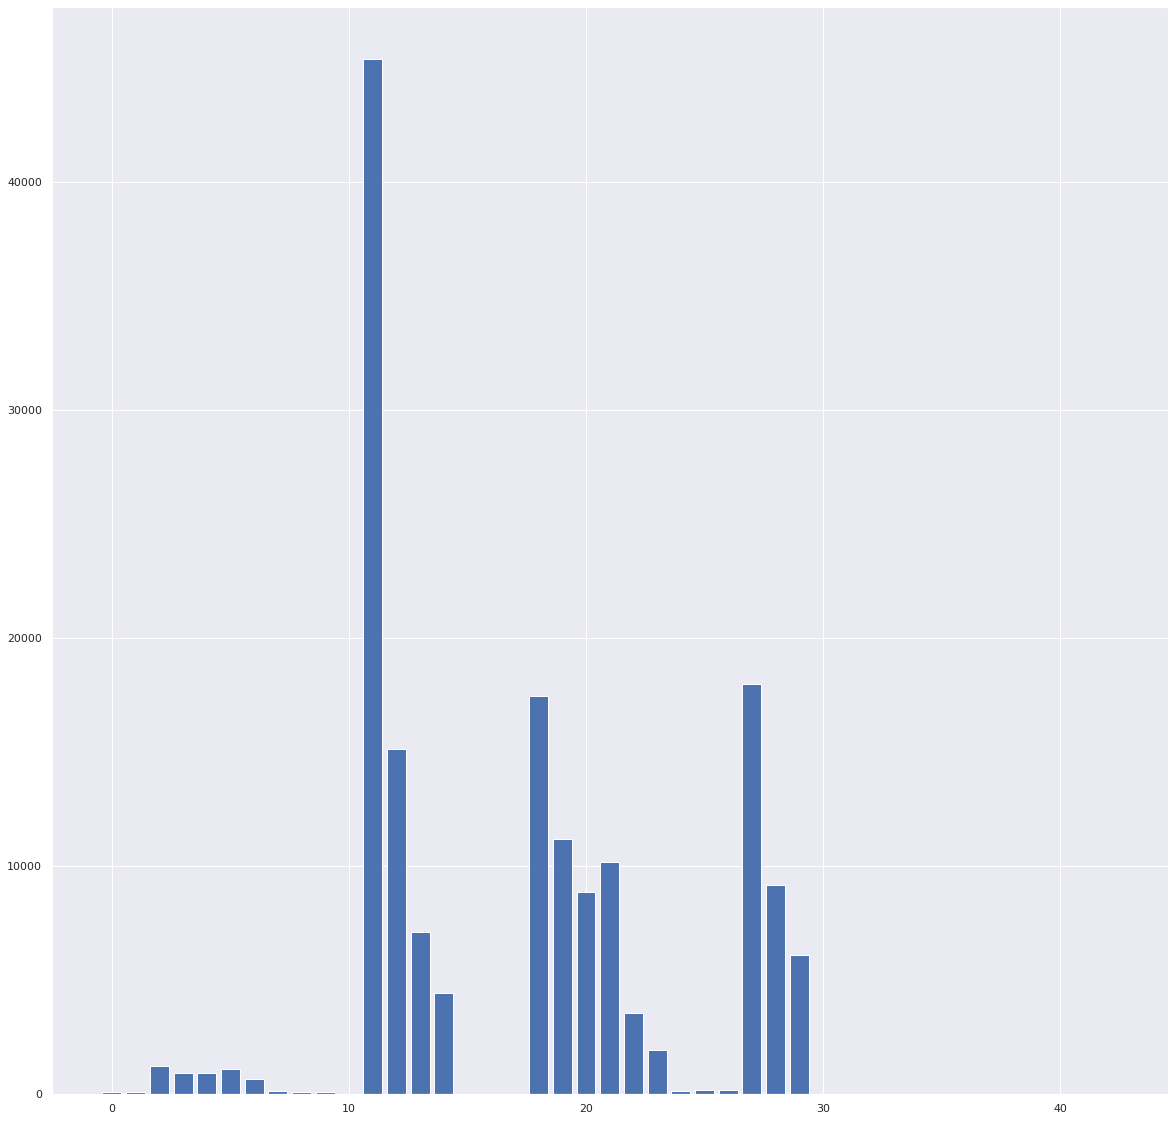

In [ ]:
def select_features(X_train, y_train):
	fs = SelectKBest(score_func=f_regression, k='all')
	fs.fit(X_train, y_train)
	return fs
fs = select_features(Xt, y)

list1 = [i for i in range(43)]

cols = Xt.columns

df = pd.DataFrame(list(zip(list1, cols, fs.scores_)), 
               columns =['i', 'col',"score"])

df = df.sort_values(by=['score'])

print(df.tail(13))

print("\n" + "------------------------------------------" + "\n")

for i in range(len(fs.scores_)):
	print('Feature {} ({}): {}'.format(i,cols[i], fs.scores_[i]))

print("\n" + "------------------------------------------" + "\n")

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

The plot shows that buy_30_std (rolling exponential mean on 5 days) , buy_30_max and Weekday are the three most important features while very low scores of around 0 were given for several other features including corona deaths and 2nd derivatives for buy rate. We were expecting the syrian rate to have some predictive value but according to our results, they are important but are not part of the 17 most important features we found to be best for performance.
We can also test a recursive feature elimination algorithm. We use RFECV to automatically select the features with best performance.

In [ ]:
def get_models():
  models = dict()
  for i in range(5,40):
    rfe = RFE(estimator = LinearRegression(), n_features_to_select=i)
    model = KNeighborsRegressor()
    models[str(i)] = Pipeline(steps=[('s',rfe),('m', model)])
  return models

def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, Xt, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>5 -943.847 (146.259)
>6 -1146.256 (218.153)
>7 -1135.208 (208.390)
>8 -1119.557 (198.810)
>9 -1078.904 (200.841)
>10 -1040.627 (210.129)
>11 -1100.608 (189.366)
>12 -1202.262 (172.217)
>13 -1393.023 (248.873)
>14 -1017.155 (176.556)
>15 -917.799 (177.848)
>16 -798.433 (313.392)
>17 -132.937 (20.848)
>18 -132.334 (21.628)
>19 -129.206 (23.678)
>20 -130.186 (26.819)
>21 -110.639 (15.060)
>22 -112.457 (13.765)
>23 -115.716 (14.150)
>24 -113.266 (14.693)
>25 -115.350 (16.557)
>26 -116.429 (17.359)
>27 -114.371 (17.260)
>28 -113.975 (20.041)
>29 -114.574 (20.706)
>30 -112.429 (22.849)
>31 -113.991 (23.301)
>32 -112.758 (23.995)
>33 -111.773 (23.570)
>34 -111.135 (23.510)
>35 -110.898 (22.458)
>36 -109.304 (21.536)
>37 -108.753 (20.721)
>38 -109.082 (20.724)
>39 -108.203 (20.737)


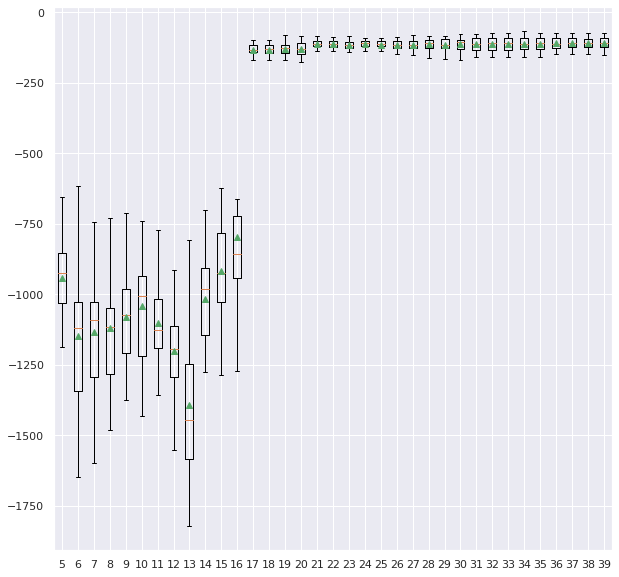

In [ ]:
plt.rcParams["figure.figsize"]=10,10
plt.boxplot(results, labels=names, showmeans=True, showfliers=False)
plt.show()

RFE selects selects 17 features as the most relevant and the ones leading to better performance. Using RFE, some other features will be included. We can check which 17 features does RFE select.

In [ ]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=17)
rfe.fit(Xt, y)
# summarize all features
for i in range(Xt.shape[1]):
	print('Column: {} ({}), Selected={}, Rank: {}'.format(i, cols[i], rfe.support_[i], rfe.ranking_[i]))

print("\n  ------------------------------------------  \n")
print("These are the selected columns: ")

for i in range(Xt.shape[1]):
	if(rfe.support_[i]==True):
		print(cols[i])


Column: 0 (Cheque Buy), Selected=True, Rank: 1
Column: 1 (Cheque Sell), Selected=True, Rank: 1
Column: 2 (Bank), Selected=False, Rank: 26
Column: 3 (SyndicateB), Selected=False, Rank: 21
Column: 4 (SyndicateS), Selected=False, Rank: 17
Column: 5 (ParallelB), Selected=False, Rank: 25
Column: 6 (SyrianRate), Selected=False, Rank: 27
Column: 7 (Confirmed Cases), Selected=False, Rank: 23
Column: 8 (Recovered Cases), Selected=False, Rank: 22
Column: 9 (Recorded Deaths), Selected=False, Rank: 3
Column: 10 (weekday), Selected=False, Rank: 11
Column: 11 (buy_1), Selected=False, Rank: 13
Column: 12 (buy_5_mean), Selected=False, Rank: 7
Column: 13 (buy_10_mean), Selected=False, Rank: 6
Column: 14 (buy_15_mean), Selected=False, Rank: 8
Column: 15 (buy_5_10), Selected=True, Rank: 1
Column: 16 (buy_10_15), Selected=True, Rank: 1
Column: 17 (buy_5_15), Selected=True, Rank: 1
Column: 18 (buy_5_max), Selected=False, Rank: 10
Column: 19 (buy_10_max), Selected=False, Rank: 19
Column: 20 (buy_15_max), Se

RFE using Kneighbors regressor drops columns 8 and 13 for instance. These are the confirmed cases and buy_15_mean. We can also see that the mean and standard deviation scores for the filter method and RFE are pretty similar, with RFE slightly better. We can investigate further the performance of our chosen model with the those two sets of features. We won't drop any columns for now as we are interested in more EDA on the whole dataset.

We now move to Data transforming, plotting the distribution of each of the features we have we get the figure below.

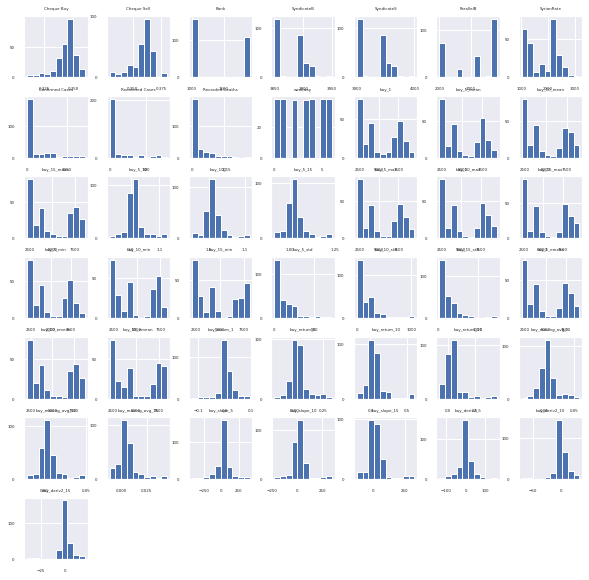

In [ ]:
ax = Xt.hist(xlabelsize=4, ylabelsize=4) #we plot the variables to check their values and distribution
[x.title.set_size(4) for x in ax.ravel()]
plt.show()

In [ ]:
Xt.head()

,Cheque Buy,Cheque Sell,Bank,SyndicateB,SyndicateS,ParallelB,SyrianRate,Confirmed Cases,Recovered Cases,Recorded Deaths,weekday,buy_1,buy_5_mean,buy_10_mean,buy_15_mean,buy_5_10,buy_10_15,buy_5_15,buy_5_max,buy_10_max,buy_15_max,buy_5_min,buy_10_min,buy_15_min,buy_5_std,buy_10_std,buy_15_std,buy_5_emean,buy_10_emean,buy_15_emean,buy_return_1,buy_return_5,buy_return_10,buy_return_15,buy_moving_avg_5,buy_moving_avg_10,buy_moving_avg_15,buy_slope_5,buy_slope_10,buy_slope_15,buy_deriv2_5,buy_deriv2_10,buy_deriv2_15
2020-01-23,0.346461,0.361483,3000.014937,3894.889846,3944.889846,2000.0,1078.963048,0.0,0.0,0.0,4.0,2100.0,2152.479787,2148.835868,2172.694634,1.008487,1.008756,1.017058,2170.098029,2180.619394,2290.395881,2153.945397,2105.888373,2105.008583,25.953985,43.720674,48.796742,2100.000000,2100.000000,2100.000000,0.014433,0.027903,0.059694,0.086113,0.005558,0.005881,0.005732,19.524232,11.577422,9.049276,1.669329,-0.238817,-0.068123
2020-01-24,0.346461,0.361483,3000.014937,3894.889846,3944.889846,2000.0,1100.000000,0.0,0.0,0.0,5.0,2150.0,2152.479787,2148.835868,2172.386862,1.008018,1.009098,1.016649,2170.098029,2180.978861,2290.395881,2153.509194,2105.888373,2105.008583,30.182694,43.720674,48.796742,2116.666667,2109.090909,2106.250000,0.023810,0.027858,0.059694,0.086090,0.005558,0.005881,0.005732,19.955473,11.577422,9.049276,1.911052,-0.238817,-0.068123
2020-01-25,0.346461,0.361483,3000.014937,3894.889846,3944.889846,2000.0,1070.000000,0.0,0.0,0.0,6.0,2150.0,2152.479787,2148.835868,2172.386862,1.008772,1.008686,1.017408,2169.582965,2180.978861,2290.395881,2153.509194,2105.888373,2105.008583,22.975473,42.299367,48.132146,2127.777778,2116.528926,2111.718750,0.000000,0.028342,0.059551,0.086227,0.005609,0.005881,0.005732,13.036422,12.281289,8.934951,1.669329,-0.238817,-0.062460
2020-01-26,0.346461,0.361483,3000.014937,3894.889846,3944.889846,2000.0,1035.000000,0.0,0.0,0.0,0.0,2160.0,2155.834591,2149.588716,2172.694634,1.008772,1.008756,1.017262,2169.582965,2181.046659,2290.547526,2153.945397,2105.888373,2104.970894,22.975473,42.299367,48.132146,2138.518519,2124.432757,2117.753906,0.004651,0.027857,0.059551,0.086043,0.005558,0.005881,0.005732,13.000000,12.281289,9.347417,1.886585,-0.238817,-0.062460
2020-01-27,0.346461,0.361483,3000.014937,3903.806194,3953.806194,2000.0,1035.000000,0.0,0.0,0.0,1.0,2160.0,2144.000000,2150.041077,2172.694634,1.008793,1.009281,1.017408,2160.000000,2179.293675,2290.525594,2100.000000,2105.888373,2104.970894,25.099801,29.375175,47.657031,2145.679012,2130.899529,2123.034668,0.000000,0.028296,0.059551,0.094401,0.005609,0.005881,0.006045,1.000000,10.889581,7.804037,-2.321862,-0.302549,-0.160509


We can clearly see that most of our features do not follow a normal distribution, also we can see differing scale for our input variables. Thus after we standardize and normalize our data, we apply power transformer. Since the days of the week is a nomial feature, we use column transformer to selectively apply scaling. We encode our nominal feature. We plot the new distribution of the input variables.

In [ ]:
Xt.head()
Xt.columns

Index(['Cheque Buy', 'Cheque Sell', 'Bank', 'SyndicateB', 'SyndicateS',
       'ParallelB', 'SyrianRate', 'Confirmed Cases', 'Recovered Cases',
       'Recorded Deaths', 'weekday', 'buy_1', 'buy_5_mean', 'buy_10_mean',
       'buy_15_mean', 'buy_5_10', 'buy_10_15', 'buy_5_15', 'buy_5_max',
       'buy_10_max', 'buy_15_max', 'buy_5_min', 'buy_10_min', 'buy_15_min',
       'buy_5_std', 'buy_10_std', 'buy_15_std', 'buy_5_emean', 'buy_10_emean',
       'buy_15_emean', 'buy_return_1', 'buy_return_5', 'buy_return_10',
       'buy_return_15', 'buy_moving_avg_5', 'buy_moving_avg_10',
       'buy_moving_avg_15', 'buy_slope_5', 'buy_slope_10', 'buy_slope_15',
       'buy_deriv2_5', 'buy_deriv2_10', 'buy_deriv2_15'],
      dtype='object')

In [ ]:
L = [i for i in range(0,10)] + [i for i in range(11,42)]
ct1 = ColumnTransformer(transformers =[ 
    ('enc', OneHotEncoder(sparse = False, drop ='first'), ["weekday"]), 
    ('num', MinMaxScaler(),L),
], remainder ='passthrough') 

ct2 = ColumnTransformer(transformers =[ 
    ('std', StandardScaler(), list(range(6,48)))
], remainder ='passthrough') 

ct3 = ColumnTransformer(transformers =[ 
    ('p', PowerTransformer(), list(range(6,42)))
], remainder ='passthrough') 

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size = 0.2)
X_train_n = ct1.fit_transform(X_train)
X_train_n1 = ct2.fit_transform(X_train_n)
X_train_n2 = ct3.fit_transform(X_train_n1)


X_test_n = ct1.transform(X_test)
X_test_n1 = ct2.transform(X_test_n)
X_test_n2 = ct3.transform(X_test_n1)

new_X_train = pandas.DataFrame(X_train_n2)
new_X_train.set_index(X_train.index, inplace = True)
new_X_train.columns = ['Cheque Buy', 'Cheque Sell', 'Bank', 'SyndicateB', 'SyndicateS',
                      'ParallelB', 'SyrianRate', 'Confirmed Cases', 'Recovered Cases',
                      'Recorded Deaths', 'buy_1', 'buy_5_mean', 'buy_10_mean',
                      'buy_15_mean', 'buy_5_10', 'buy_10_15', 'buy_5_15', 'buy_5_max',
                      'buy_10_max', 'buy_15_max', 'buy_5_min', 'buy_10_min', 'buy_15_min',
                      'buy_5_std', 'buy_10_std', 'buy_15_std', 'buy_5_emean', 'buy_10_emean',
                      'buy_15_emean', 'buy_return_1', 'buy_return_5', 'buy_return_10',
                      'buy_return_15', 'buy_moving_avg_5', 'buy_moving_avg_10',
                      'buy_moving_avg_15', 'buy_slope_5', 'buy_slope_10', 'buy_slope_15',
                      'buy_deriv2_5', 'buy_deriv2_10', 'buy_deriv2_15',
                      "Weekday_1","Weekday_2","Weekday_3","Weekday_4","Weekday_5","Weekday_6"]
new_X_train.head()


,Cheque Buy,Cheque Sell,Bank,SyndicateB,SyndicateS,ParallelB,SyrianRate,Confirmed Cases,Recovered Cases,Recorded Deaths,buy_1,buy_5_mean,buy_10_mean,buy_15_mean,buy_5_10,buy_10_15,buy_5_15,buy_5_max,buy_10_max,buy_15_max,buy_5_min,buy_10_min,buy_15_min,buy_5_std,buy_10_std,buy_15_std,buy_5_emean,buy_10_emean,buy_15_emean,buy_return_1,buy_return_5,buy_return_10,buy_return_15,buy_moving_avg_5,buy_moving_avg_10,buy_moving_avg_15,buy_slope_5,buy_slope_10,buy_slope_15,buy_deriv2_5,buy_deriv2_10,buy_deriv2_15,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
2020-05-17,0.053175,-0.713335,-0.733244,-0.782454,-0.411603,-0.373289,-0.317256,-0.295294,-0.903079,-0.261563,-0.674905,-0.372441,-0.365906,-0.379237,-0.333482,-0.251940,-0.162400,-0.237271,-0.549835,-0.861250,-0.378098,-0.348484,-0.341188,-0.216619,-1.147074,-0.746119,-0.316992,-1.161365,-0.763311,-0.333465,-0.190710,-0.519209,-0.334001,0.119340,-0.594243,-0.660170,0.684610,0.365619,-0.837378,1.510452,1.510452,0.105699,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-15,-0.300316,-0.765233,-0.421045,-0.782454,-0.411603,-0.344911,-0.310107,-0.301752,-0.449568,0.037289,-0.221091,-0.349886,-0.365906,-0.379237,-0.333482,-0.251940,-0.216058,0.071251,-0.695414,-0.662674,-0.362031,-0.340186,-0.341638,-0.216619,-0.722953,-0.440702,-0.066363,-0.726030,-0.452012,-0.080411,-0.706929,-0.440794,-0.150530,-0.441197,-0.463917,-0.675154,0.614896,0.365619,-0.837378,1.087421,1.087421,0.105699,0.0,0.0,0.0,0.0,1.0,0.0
2020-06-24,1.281056,-0.550929,-0.572830,0.258619,0.638306,0.425331,0.249816,0.189746,2.308019,1.143124,1.837703,0.579424,0.543391,0.516136,0.263953,-0.002927,0.044072,1.681876,1.696845,1.476868,0.440189,0.310800,0.233271,3.090019,2.925688,2.267086,1.886176,2.931016,2.285780,1.928613,2.835393,2.377251,1.643467,0.722542,2.143262,0.830539,-0.136360,1.157173,-0.837378,-1.046415,-1.046415,0.891708,0.0,0.0,1.0,0.0,0.0,0.0
2020-09-05,0.732066,1.532463,1.764452,1.373163,0.893532,0.912268,0.954238,0.971616,-0.573000,-0.215268,-0.441496,0.860857,0.915354,0.878735,0.961859,0.992062,1.042988,-0.183801,0.793440,0.426242,0.914855,0.936873,0.961023,-0.709903,0.340803,-0.609166,-0.012595,0.331087,-0.585401,0.004822,-0.001135,-0.318435,-0.340993,0.065261,-1.113352,-0.352947,0.458841,-0.174043,1.209158,-1.046415,-1.046415,0.891677,0.0,0.0,0.0,0.0,0.0,1.0
2020-09-16,0.694690,1.618115,1.871456,1.653142,1.016914,1.019971,1.041740,1.043308,-0.277079,0.035569,-0.117969,0.945788,0.947804,0.910272,1.103624,1.136258,1.183664,-1.009442,-0.286090,-0.123903,1.024443,1.038780,1.053313,0.029624,-0.636780,-0.055176,0.026082,-0.650791,-0.071263,0.004607,-0.143424,-0.164018,0.172452,0.119340,-0.454085,0.217265,0.346045,-0.204190,1.209158,-1.046415,-1.046415,0.891677,0.0,0.0,1.0,0.0,0.0,0.0


We also remove seasonality trend from the target variable.

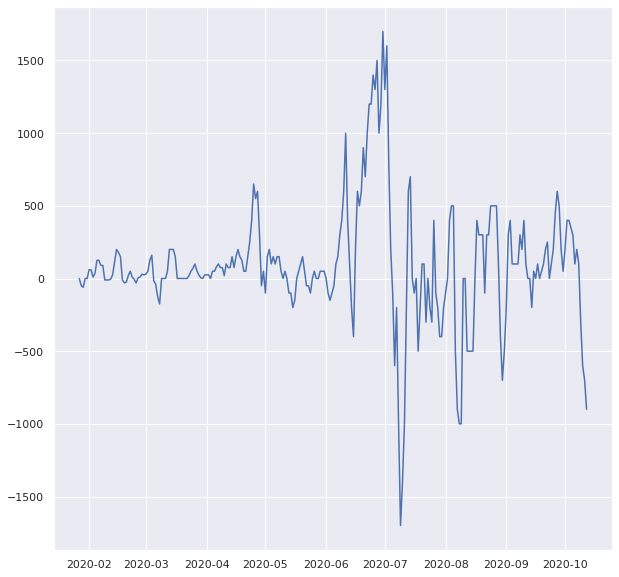

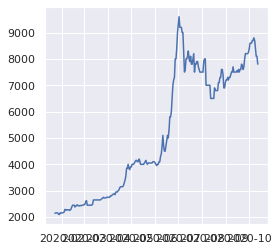

In [ ]:
y_new = y.values
y_new = y.diff(4) #we apply differentation to remove seasonality from our data
plt.plot(y_new)
plt.rcParams["figure.figsize"]=4,4
plt.show()
plt.plot(y) #we compare new date to the one we had before
plt.rcParams["figure.figsize"]=4,4
plt.show()

Feature Engineering: since our intended model would benefit from polynomial features, it is good to try and explore with feature crossing and polynomialTransform. We will see which degree of polynomial transforms perform better. We evaluate degrees 1, 2 and 3.

>1 -113.179 (17.674)
>2 -119.259 (21.403)
>3 -129.116 (21.004)


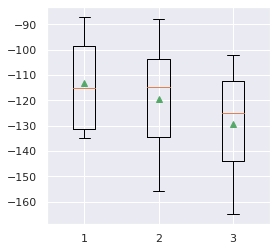

In [ ]:
def get_models():
	models = dict()
	for d in range(1,4):
		trans = PolynomialFeatures(degree=d)
		model = KNeighborsRegressor()
		models[str(d)] = Pipeline(steps=[('t', trans), ('m', model)])
	return models

def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, Xt, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
 
# we plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Our feature engineering test suggests that polynomial degrees hurt the performance of the model and better performance was achieved with degree of 1. W

Let's briefly explore the numerical data correlation alone, before merging with the NLP derived features (that have underwent their own selection and engineering)

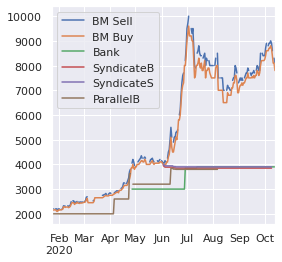

In [ ]:
merge[["BM Sell","BM Buy","Bank","SyndicateB","SyndicateS","ParallelB"]].plot()
#all rates are behaving similarly which shows that they are all being affected and show similar trends.

We will check correlation between the variables in our data. We do this by drawing the following heatmap.

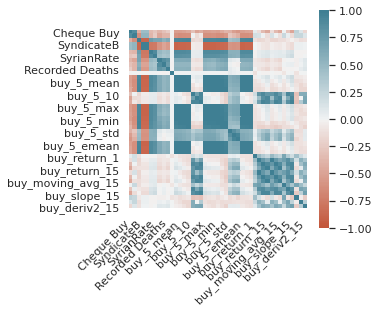

In [ ]:
corr = X_train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

This heatmap reveals some intersting features like a correlation between the syrian rate and parallel rate (like seen in the plots).
A heavy correlation in the corona is seen like in the plots.
We can also see some correlation between the rates and the corona cases.
We also see negative correlation between cheque rates and other rates which is normal as cheque price are considered as ratios.

Now its time to import the tweets, which have undergone heavy filtering and selection. The dataset consists of 8 categories of columns, essentially the cartesian product of (eng,arab) and (keywords,lebanongeneral) (frequencies, sentiments). The first 3 letters of the column indicate what category it belongs to, and if it is of type frequency, the word itself follows. If it is of type sentiment, "neg", "neu", or "pos" follow. Only the 5 words with the highest variance where chosen for each frequency category, and stopword elimination was done on English, after frequency standardization. We will combine the dataset with the full numerical dataset and perform more comprehensive EDA on both

NOTE THE DIAGRAM MIGHT REQUIRE YOU TO RUN THE CODE TO RENDER PROPERLY (because using a custom size that is not the default)

Index(['ekspos', 'eksneu', 'eksneg', 'ekflebanese', 'ekflebanon', 'ekflollar',
       'ekfdollar', 'ekflebaneselira', 'elspos', 'elsneu', 'elsneg',
       'elflebanon', 'elfbeirut', 'elfiraq', 'elfiran', 'elfyara_lebanon',
       'akspos', 'aksneu', 'aksneg', 'akfالدولار', 'akfفي', 'akfمصرف', 'akfمن',
       'akfدولار', 'alspos', 'alsneu', 'alsneg', 'alfمن', 'alfلبنان', 'alfو',
       'alfفي', 'alfلبنان_ينتفض'],
      dtype='object')
Index(['Cheque Buy', 'Cheque Sell', 'Bank', 'SyndicateB', 'SyndicateS',
       'ParallelB', 'SyrianRate', 'Confirmed Cases', 'Recovered Cases',
       'Recorded Deaths', 'buy_1', 'buy_5_mean', 'buy_10_mean', 'buy_15_mean',
       'buy_5_10', 'buy_10_15', 'buy_5_15', 'buy_5_max', 'buy_10_max',
       'buy_15_max', 'buy_5_min', 'buy_10_min', 'buy_15_min', 'buy_5_std',
       'buy_10_std', 'buy_15_std', 'buy_5_emean', 'buy_10_emean',
       'buy_15_emean', 'buy_return_1', 'buy_return_5', 'buy_return_10',
       'buy_return_15', 'buy_moving_avg_5', 'buy_moving

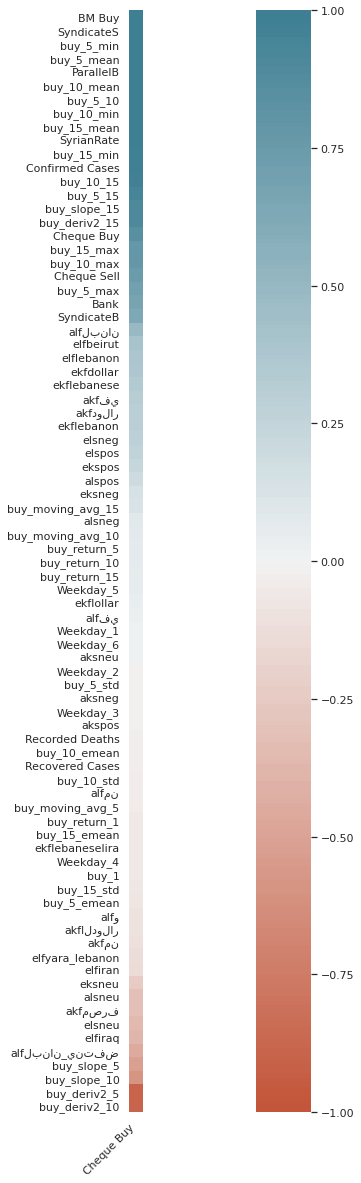

In [ ]:
lang = pandas.read_csv("/content/drive/My Drive/finally.csv",index_col=0)

print(lang.columns)
# these are the words which were chosen using the previous unsupervised methods. They seem satisfactory
#a few stop words made it through in arabic.
#now lets merge this with the other one.
#also, we will reinclude the target variable so that we may study how all the inputs correlate to it.
df = new_X_train.merge(lang, left_index=True, right_index=True)
df=df.merge(y_train,left_index=True, right_index=True)
print(df.columns)
#now lets get some correlation plots
corr = df.corr()[['BM Buy']].sort_values(by='BM Buy', ascending=False)
print("hi",corr['BM Buy'])
sns.set(rc={'figure.figsize':(40.7,20.27)})
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    yticklabels = 1
)
lbl=[str(x) for x in df.columns]
ax.set_xticklabels(
    lbl,
    rotation=45,
    horizontalalignment='right'
);

Now that has lots of information to analyze!

-On the positive end of the correlation we find the moving averages of the variable itself. This is expected, and indicates to us that this problem is amenable to time series analysis using previous values to construct a regressor.

-As we previously found out, there is a correlation between covid cases and the dollar rate. While stunning, I find this dubious, and will carry out further investigation there.

-The words Lebanon (arabic) and dollar were deemed positive, which makes sense.

-Most sentiments were deemed useless, and are clustered around the 0 correlation area.

-The syndicate variables are most negatively correlated with the rate, which is ironic.

-The words "lobnan yantafid" (Arabic) and "masrif" (Arabic), as well as iraq were deemed the most negatively correlated, along with neutral sentiments. 

For the covid correlation, I hypothesize that (sardonically) the only reason they are correlated is that both situations are consistenly getting worse with time, so time is the underlying common denominator.



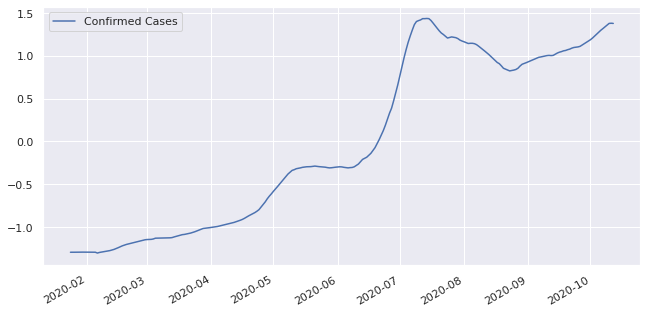

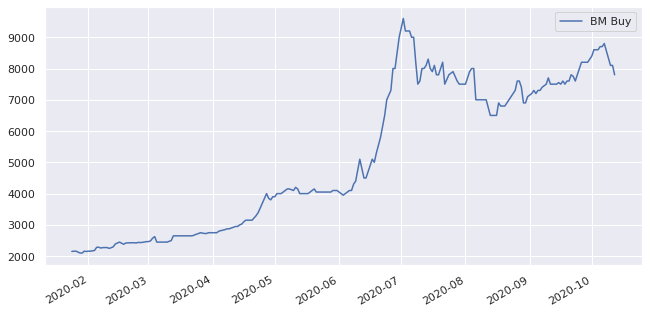

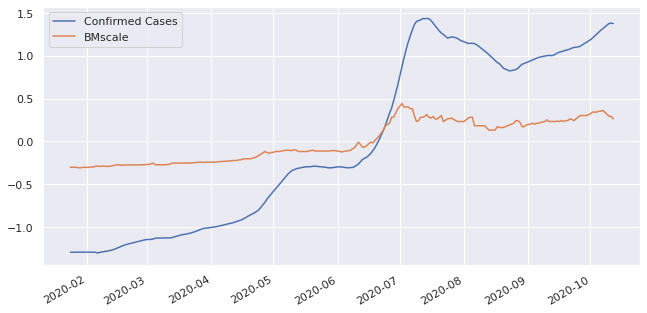

In [ ]:
sns.set(rc={'figure.figsize':(10.7,5.27)})
df[['Confirmed Cases']].plot( use_index=True)
df[['BM Buy']].plot(use_index=True)
##scale the lira just so we can see the fluctations on the same figure
df['BMscale']=df['BM Buy']/10000
#in order to see correlation, lets subtract mean from both
df['CCm']=df['Confirmed Cases']-df['Confirmed Cases'].mean()
df['BMscale']=df['BMscale']-df['BMscale'].mean()
df[['Confirmed Cases','BMscale']].plot( use_index=True)



I'm not sure that these exactly fluctuate together. In fact, they show opposite trends if we consider their post July mean. The correlation might not be as valid as it initially seemed. All the same, that is not enough evidence to drop the rate.

Now let's check out the curves of most of the previously deemed relevant tweets:

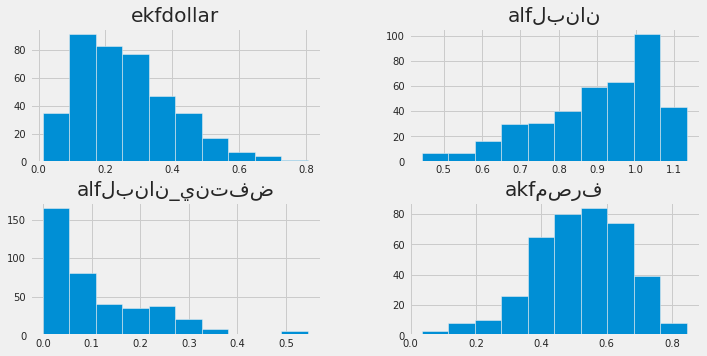

              ekspos    eksneu    eksneg  ...   alfو  alfفي  alfلبنان_ينتفض
2019-10-01  0.062736  0.851830  0.085415  ...  0.218  0.395           0.000
2019-10-02  0.102532  0.791426  0.106170  ...  0.342  0.526           0.000
2019-10-03  0.077880  0.850500  0.071600  ...  0.383  0.631           0.000
2019-10-04  0.099439  0.814073  0.086463  ...  0.332  0.610           0.001
2019-10-05  0.081474  0.833895  0.084579  ...  0.358  0.598           0.000

[5 rows x 32 columns]
smoothed data with forest 0.8629091299556635
unsmoothed data with forest 0.5663683200359141
smoothed data with regressor 0.6824208664380065
unsmoothed data with regressor 0.039998660897565735


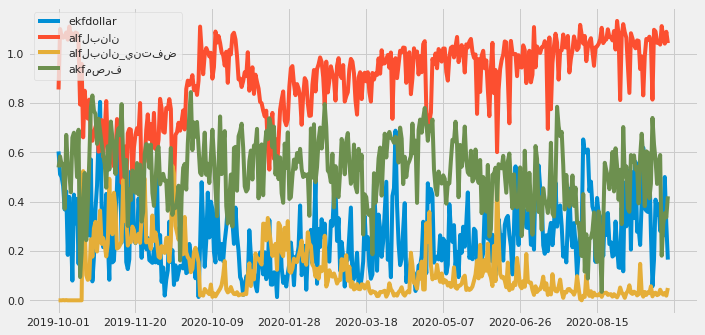

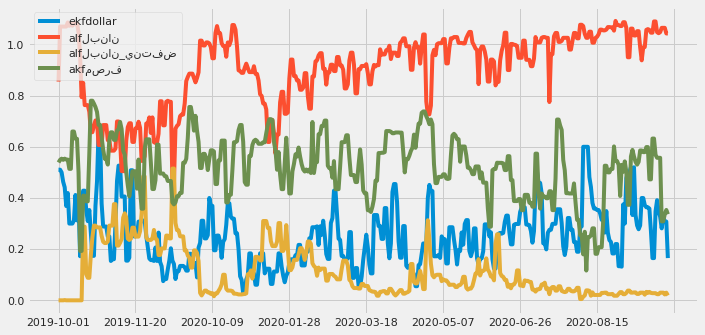

In [ ]:
lang = pandas.read_csv("/content/drive/My Drive/finally.csv",index_col=0)
#we only look at the most interesting tweets to avoid crowing the diagram
ax = lang[['ekfdollar','alfلبنان','alfلبنان_ينتفض','akfمصرف']].hist(xlabelsize=10, ylabelsize=10) #we plot the variables to check their values and distribution
#the variables are not necessarily normal, we note that a power transform in phase 3 might be suitable 
plt.show()






lang[['ekfdollar','alfلبنان','alfلبنان_ينتفض','akfمصرف']].plot()

#this is very noisy.. lets try smoothening it with scipy median filter!

from scipy.signal import medfilt
from scipy.signal import savgol_filter
lang2=lang.apply(medfilt, axis=0)
print(lang.head())
lang2[['ekfdollar','alfلبنان','alfلبنان_ينتفض','akfمصرف']].plot()
#visually, it looks better
#for the sake of it, lets try a simple regressor to see if smoothing positive impact, using only the language dataframe
dfl2=lang2.merge(y_train,left_index=True, right_index=True)
dfl=lang.merge(y_train,left_index=True, right_index=True)
dfl2=dfl2.drop('BM Buy', axis=1)
dfl=dfl.drop('BM Buy', axis=1)
basic=RandomForestRegressor()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(basic, dfl2, y_train, scoring="r2", cv=cv, n_jobs=-1)
print("smoothed data with forest",mean(scores))
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(basic, dfl, y_train, scoring="r2", cv=cv, n_jobs=-1)
print("unsmoothed data with forest",mean(scores))
basic=LinearRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(basic, dfl2, y_train, scoring="r2", cv=cv, n_jobs=-1)
print("smoothed data with regressor",mean(scores))
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(basic, dfl, y_train, scoring="r2", cv=cv, n_jobs=-1)
print("unsmoothed data with regressor",mean(scores))

We discovered that the tweets are best treated like signals, and need some smoothing, particular for apparently value sensitive models like linear regression. Even the forests did better with the smoothing.


Now that we have an idea of what's relevant and what isn't, let's do some PCA to see how many columns we _really_ need.

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [80] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


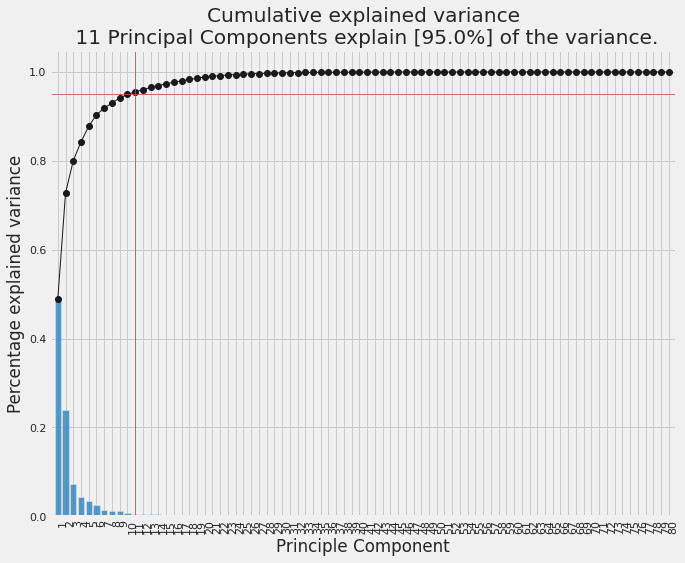

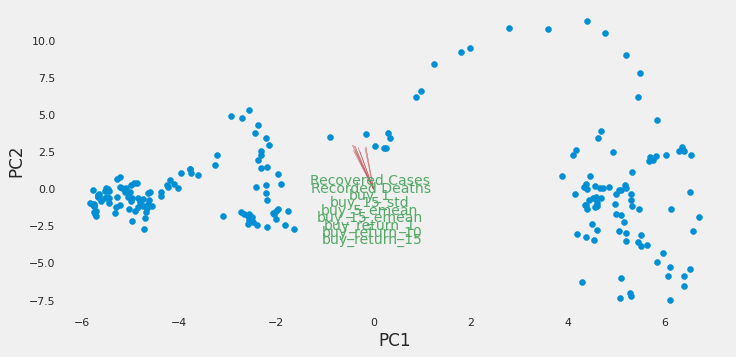

In [ ]:
!pip install pca

from pca import pca as PCA2
df=new_X_train.merge(dfl2,left_index=True, right_index=True)
pca = PCA2()
newdf=pca.fit_transform(df)


fig, ax = pca.plot()
#change the PCA library because the other one did not render the vector plot properly and has less documentation online
from sklearn.decomposition import PCA 
pca=PCA()
pca.fit(df)
x_new = pca.transform(df) 

##################code is courtesy of seralouk on stack overflow
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    plt.scatter(xs ,ys) #without scaling
    prev=0
    for i in range(n):
        if(abs(coeff[i,0])<0.25 and abs(coeff[i,1])<0.25):
          continue
        plt.arrow(0, 0, 10*coeff[i,0], 10*coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 2, coeff[i,1] * 2, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 2, coeff[i,1] * 2-prev, labels[i], color = 'g', ha = 'center', va = 'center')
            prev+=0.5
##################
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
 
myplot(x_new[:,0:2], pca.components_.T,df.columns) 
plt.show()


#the dominant features in the first two components are evidently the rate related ones.
#i think combining them would be counterproductive because even though they are obviously linear functions of each other
#they play an important role in determining the autoregression part
#so we would like to preserve them as distinct variables
#not because of the statistical variance that they provide
#but because of their temporal importance


The dominant features in the first two components are evidently the rate related ones (and covid). I think combining them would be counterproductive because even though they are obviously linear functions of each other. They play an important role in determining the autoregression part. So we would like to preserve them as distinct variables not because of the statistical variance that they provide but because of their temporal importance.

We notice interestingly a parabolic (-n^2 like), highly nonlinear distribution to the examples based on the features derived throught the PCA. Let's see if we can get some useful cluster information from this

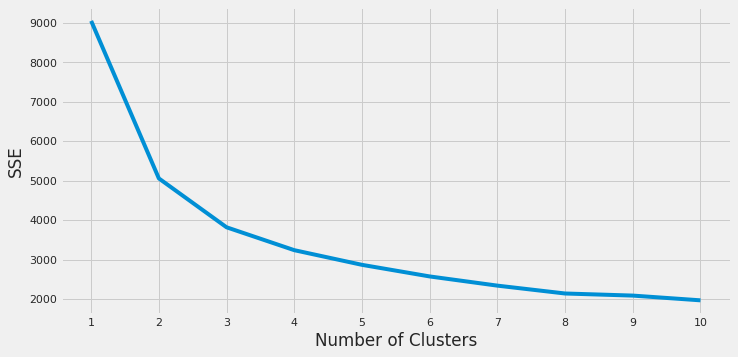

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()



 the elbow is around 2-3.
this might makes sense according to the pca graph, which can be thought of as 2 clusters, or 3, 
if we consider the upper ridge of the parabola.
lets check the clusters out with respect to their dates

                 PC1       PC2       PC3  ...       PC9      PC10      PC11
2020-05-17 -2.185174 -2.579520  0.565398  ...  0.126173 -0.017334  0.937584
2020-05-15 -2.075799 -1.622927  0.973150  ... -0.395344 -0.398918  0.652607
2020-06-24  1.236875  8.437514 -3.756200  ... -0.481145 -0.562157 -0.164643
2020-09-05  4.608376 -0.919545 -0.399677  ... -1.289308 -0.023778 -0.767244
2020-09-16  4.525969 -0.583927 -0.139700  ...  0.176769 -0.585273 -0.863147
...              ...       ...       ...  ...       ...       ...       ...
2020-06-04 -1.630447 -2.700193 -0.548185  ...  0.305727  0.160059  0.246341
2020-05-31 -2.672686 -1.686265 -0.667366  ... -0.631575  0.628246  0.878857
2020-01-29 -5.620057 -0.779613  1.605638  ...  0.802544 -0.178661  0.055996
2020-09-13  4.570472  0.232210 -0.344042  ... -0.141122 -0.896270 -0.532725
2020-09-25  5.087777 -0.036464 -0.409806  ... -0.217836 -0.675159  0.105968

[211 rows x 11 columns]


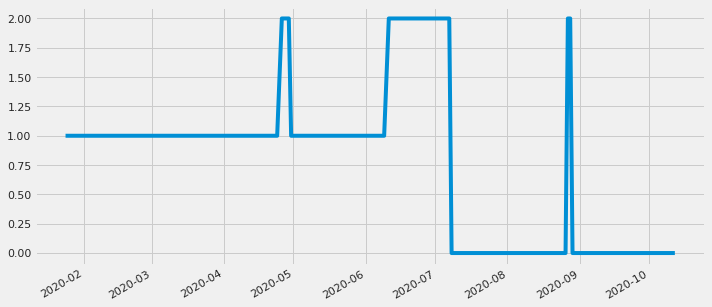

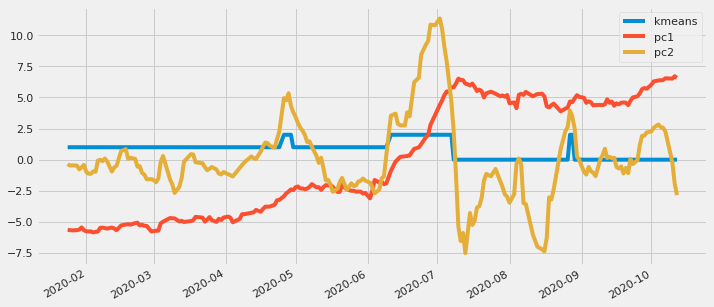

In [ ]:

kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=50
)
kmeans_x = kmeans.fit(new_X_train)

df['kmeans']=kmeans_x.labels_
df['kmeans'].plot(use_index=True)

# we observe a presummer phase, a summer phase and a post summer phase.
#i believe that this correlates to the variation
#to test, lets plot PC1 and PC2 with this and see if it confirms our suspicions:
print (newdf['PC'])
col1 = newdf['PC']['PC1']
col2=newdf['PC']['PC2']
df['pc1']=col1
df['pc2']=col2
df[['kmeans','pc1','pc2']].plot(use_index=True)



# Almost a perfect match. The clusters practically follow the PCA!!!! 

Note that even though we are plotting the numerical value of the cluster, we do not particularly care about its value, only of when it changes. Notice that the 2 main clusters, before summer, and after summer, are expplained by the most important PC1 variable, while the central cluster and any spikes are explained by the secondary PC2 column.

Thus, from this entire excersize, we gain valuable lessons about our data

1)The data seems to be roughly split into 3 times, pre summer, summer, and post summer. This roughly corresponds to national events and phases (lockdown, summer inflation and reopnineg, and post explosion)

**2) The clusters strongly agree with the PCA, which corroborates this confirmation. The PCA's are constructed from mainly the rate averages, which point to the strong autoregression nature of this problem.** 

3)The correlation plot shows that sentiments do not have a significant importance (apart from maybe neutral), but certain words as mentioned above play an important role in determining fluctuations.


